# Kuramoto-Sivashinsky Partial Differential Equation Prediction

In this example, we predict the time evolution of a chaotic partial differential equation. The PDE of interest is the [Kuramoto-Sivashinsky equation](https://en.wikipedia.org/wiki/Kuramoto%E2%80%93Sivashinsky_equation). 
## Kuramoto-Sivashinsky Equation 
The Kuramoto-Sivashinsky equation is a fourth-order nonlinear partial differential equation used to model diffusive-thermal instabilities in a laminar flame front. The 1d version of the equation is $$\frac{\partial u}{\partial t} + \frac{\partial^2 u}{\partial x^2} + \frac{\partial^4 u}{\partial x^4} + \frac12 \frac{\partial (u^2)}{\partial x} = 0$$ This equation is known for demonstrating spatiotemporal chaos.

## Numerical Approximation Method
For computational efficiency, we can solve the linear and nonlinear components of the PDE separately. We use ETDRK4 (Exponential Time Differencing and 4th-Order Runge Kutta) with spectral methods to numerically approximate the PDE.

In [1]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt

@dataclass 
class SpaceParameters: 
    L: float = 64 
    N: int = 128

@dataclass
class TimeParameters: 
    dt: float = 0.05 
    tmax: float = 100.0

def kuramoto_sivashinsky(space_: SpaceParameters, time_: TimeParameters) -> np.typing.NDArray:
    """ Approximate solution to the Kuramoto-Sivashinsky equation using ETDRK4 """
    N = space_.N              
    L = space_.L         
    
    x = np.linspace(0, L, N, endpoint=False)
    k = np.fft.fftfreq(N, d=L/N) * 2 * np.pi
    k = 1j * k
    
    dt = time_.dt           
    T = time_.tmax        
    nsteps = int(T / dt)
    
    np.random.seed(0) # Fix the seed for deterministic behavior
    u = 0.1 * np.random.randn(N)
    v = np.fft.fft(u)
    
    Lhat = -k**2 - k**4
    E = np.exp(Lhat * dt)
    E2 = np.exp(Lhat * dt / 2)
    
    M = 32
    r = np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)
    LR = dt * Lhat[:, None] + r
    Q = dt * np.mean((np.exp(LR / 2) - 1) / LR, axis=1)
    f1 = dt * np.mean((-4 - LR + np.exp(LR)*(4 - 3*LR + LR**2)) / LR**3, axis=1)
    f2 = dt * np.mean((2 + LR + np.exp(LR)*(-2 + LR)) / LR**3, axis=1)
    f3 = dt * np.mean((-4 - 3*LR - LR**2 + np.exp(LR)*(4 - LR)) / LR**3, axis=1)
    
    t_output = np.linspace(0, T, 400)
    usave = []
    
    # Dealiasing mask (2/3 rule)
    kcut = N // 3
    dealias = np.zeros(N)
    dealias[:kcut] = 1
    dealias[-kcut:] = 1

    # Time stepping
    for i in range(nsteps):
        u_phys = np.fft.ifft(v).real
        Nv = -0.5j * k * np.fft.fft(u_phys ** 2)
        Nv *= dealias

        a = E2 * v + Q * Nv
        Na = -0.5j * k * np.fft.fft(np.fft.ifft(a).real ** 2)
        Na *= dealias

        b = E2 * v + Q * Na
        Nb = -0.5j * k * np.fft.fft(np.fft.ifft(b).real ** 2)
        Nb *= dealias

        c = E2 * a + Q * (2*Nb - Nv)
        Nc = -0.5j * k * np.fft.fft(np.fft.ifft(c).real ** 2)
        Nc *= dealias
        
        v = E * v + Nv * f1 + 2*(Na + Nb) * f2 + Nc * f3
        
        usave.append(np.fft.ifft(v).real.copy())
    
    return np.array(usave)

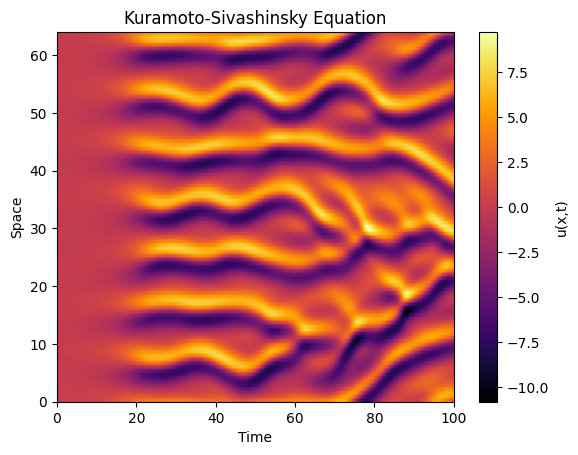

In [2]:
# Space Params
L = 64
N = 100

# Time Params 
DT = 0.05
T_MAX = 100

x = np.arange(0, L, L/N)
t = np.arange(0, T_MAX, DT)

X,Y = np.meshgrid(x, t)

snapshots = kuramoto_sivashinsky(SpaceParameters(L=L, N=N), TimeParameters(dt=DT, tmax=T_MAX))

# Plot the results
plt.imshow(snapshots.T, aspect='auto', extent=[0, T_MAX, 0, L], cmap='inferno', origin='lower')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Kuramoto-Sivashinsky Equation')
plt.colorbar(label='u(x,t)')
plt.show()


As you can see, the field produced demonstrates spatiotemporal chaos. We will use `aqua_blue_hyperopt` for model hyperparameter optimization.

In [3]:
import aqua_blue_hyperopt
from aqua_blue.time_series import TimeSeries # type: ignore
from aqua_blue.utilities import Normalizer # type: ignore
from aqua_blue.models import Model #type: ignore
from aqua_blue.reservoirs import DynamicalReservoir #type: ignore
from aqua_blue.readouts import LinearReadout #type: ignore

# Space Params
L = 64
N = 100
space_ = SpaceParameters(L=L, N=N)

# Time Params
DT = 0.01
T_MAX = 100
time_ = TimeParameters(dt=DT, tmax=T_MAX)

HORIZON = 500

snapshots = kuramoto_sivashinsky(space_, time_)

TRAIN_DATA = snapshots[:snapshots.shape[0]-(HORIZON-1), :]
TEST_DATA = snapshots[-HORIZON:, :]

t = np.arange(0, T_MAX, DT)
ts = TimeSeries(
    dependent_variable=TRAIN_DATA, 
    times=t
)

mp = aqua_blue_hyperopt.hyper.ModelParams(
    time_series=ts, 
    input_dimensionality=N, 
    reservoir_dimensionality=500,
    horizon=HORIZON,
    actual_future=TEST_DATA
)

opt = aqua_blue_hyperopt.hyper.Optimizer(
    fn=aqua_blue_hyperopt.hyper.default_loss(mp), 
    algo=aqua_blue_hyperopt.hyper.Algo.TREE_PARZEN_ESTIMATOR,  
    max_evals = 1000
)

best = opt.optimize()

# Model Params 
LEAKING_RATE = best['leaking_rate']
SPECTRAL_RADIUS = best['spectral_radius']
RIDGE_COEFFICIENT = best['rcond']
SPARSITY = best['sparsity']

100%|██████████| 1000/1000 [36:11<00:00,  2.17s/trial, best loss: 1.6615498088284926]


Now, let's use these optimal hyperparameters to make a prediction.

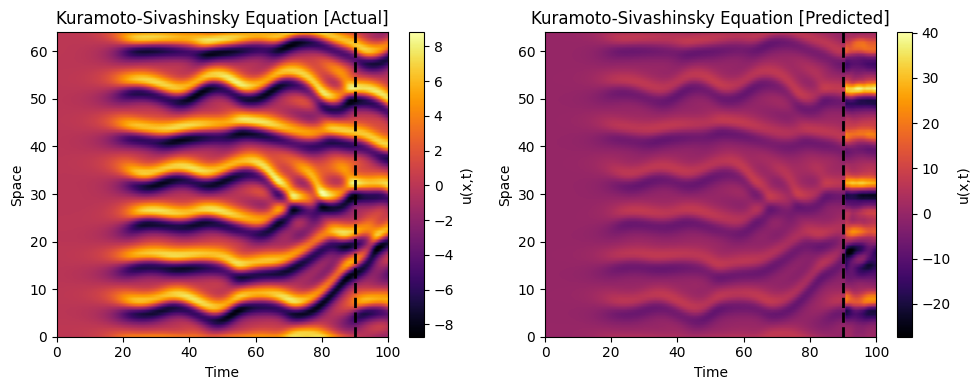

In [4]:
HORIZON = 1000
normalizer = Normalizer()
time_series = normalizer.normalize(ts)

model = Model(
    reservoir=DynamicalReservoir(
        input_dimensionality=N,
        reservoir_dimensionality=500,
        leaking_rate=LEAKING_RATE,
        spectral_radius=SPECTRAL_RADIUS,
        sparsity=SPARSITY
    ),
    readout= LinearReadout(rcond=RIDGE_COEFFICIENT)
)

model.train(ts)
predictions = model.predict(HORIZON)
predictions = normalizer.denormalize(predictions)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im0 = axs[0].imshow(snapshots.T, aspect='auto', extent=[0, time_.tmax, 0, space_.L], cmap='inferno', origin='lower')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Space')
axs[0].set_title('Kuramoto-Sivashinsky Equation [Actual]')
axs[0].axvline(x=T_MAX*(1 - HORIZON/snapshots.shape[0]), color='black', linestyle='--', linewidth=2, label='Prediction Horizon')
fig.colorbar(im0, ax=axs[0], label='u(x,t)')

im1 = axs[1].imshow(np.vstack((TRAIN_DATA, predictions.dependent_variable)).T, aspect='auto', extent=[0, time_.tmax, 0, space_.L], cmap='inferno', origin='lower')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Space')
axs[1].set_title('Kuramoto-Sivashinsky Equation [Predicted]')
axs[1].axvline(x=T_MAX*(1 - HORIZON/snapshots.shape[0]), color='black', linestyle='--', linewidth=2)
fig.colorbar(im1, ax=axs[1], label='u(x,t)')

plt.tight_layout()
plt.show()

In [5]:
print(best)

{'leaking_rate': np.float64(0.017952085819826824), 'rcond': np.float64(0.0004385062449276354), 'sparsity': np.float64(0.3905713216165534), 'spectral_radius': np.float64(1.3701842414147454)}
